In [3]:
pip install efficientnet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from efficientnet.tfkeras import EfficientNetB0  # Import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Preparing the data
import pathlib

In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Setting the path to the dataset directory
data_dir = r"/content/drive/MyDrive/Thesis_Kidney_Stone"
data_dir = pathlib.Path(data_dir)

In [8]:
img_height, img_width = 224, 224
batch_size = 64

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 1440 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 359 files for validation.


In [21]:
# Training the model
EfficientNet_model = Sequential()
IMAGE_SIZE = [224, 224]
efficientnet = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
efficientnet.trainable = False

In [22]:
folders=glob("/content/drive/MyDrive/Thesis_Kidney_Stone/*")
print(len(folders))

2


In [23]:
from tensorflow.keras.models import Model
x = GlobalAveragePooling2D()(efficientnet.output)  # Use GlobalAveragePooling2D instead of Flatten
x = Dense(128, activation='relu')(x)  # Increase the number of neurons
predictions = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=efficientnet.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']       

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])  # Adjust learning rate

In [27]:
epochs = 50
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs
)

Epoch 1/50
23/23 [==============================] - 44s 1s/step - loss: 0.5202 - accuracy: 0.8035 - val_loss: 0.4846 - val_accuracy: 0.8189
Epoch 2/50
23/23 [==============================] - 32s 980ms/step - loss: 0.5278 - accuracy: 0.8042 - val_loss: 0.4903 - val_accuracy: 0.8217
Epoch 3/50
23/23 [==============================] - 34s 1s/step - loss: 0.5167 - accuracy: 0.8062 - val_loss: 0.4850 - val_accuracy: 0.8217
Epoch 4/50
23/23 [==============================] - 33s 1s/step - loss: 0.5328 - accuracy: 0.8042 - val_loss: 0.4886 - val_accuracy: 0.8217
Epoch 5/50
23/23 [==============================] - 31s 1s/step - loss: 0.5248 - accuracy: 0.8028 - val_loss: 0.4896 - val_accuracy: 0.8217
Epoch 6/50
23/23 [==============================] - 32s 953ms/step - loss: 0.5087 - accuracy: 0.8042 - val_loss: 0.5033 - val_accuracy: 0.8189
Epoch 7/50
23/23 [==============================] - 35s 1s/step - loss: 0.5337 - accuracy: 0.8069 - val_loss: 0.5154 - val_accuracy: 0.8134
Epoch 8/50
23/

In [28]:
best_accuracy = max(history.history['accuracy'])
print("Best Training Accuracy:", best_accuracy)

best_accuracy1 = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_accuracy1)

Best Training Accuracy: 0.8083333373069763
Best Validation Accuracy: 0.8245125412940979


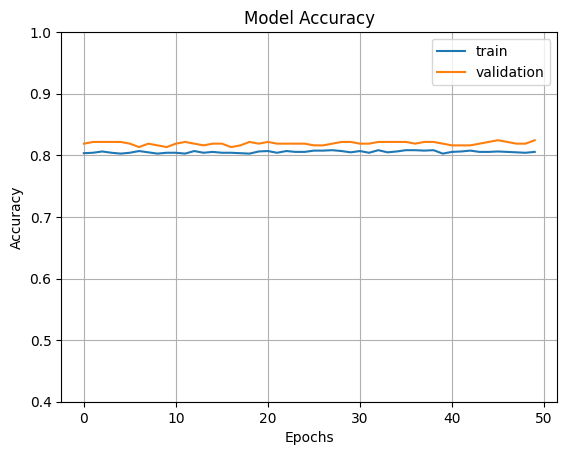

In [29]:
# Evaluating the model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

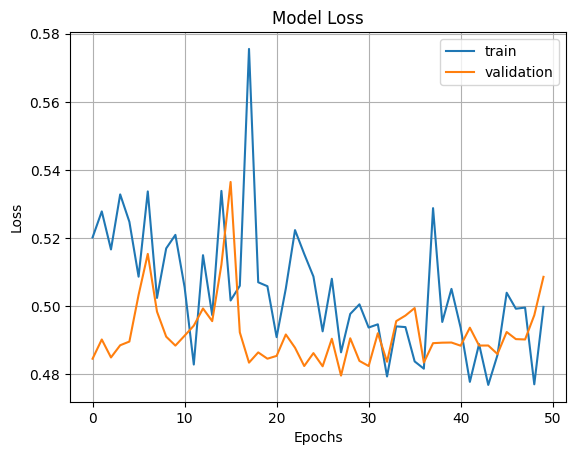

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [31]:
# Generate predictions for the validation dataset
val_predictions = model.predict(val_ds)

# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Get true labels for the validation dataset
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_true_labels = np.argmax(val_true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

6/6 [==============================] - 9s 119ms/step


In [32]:
# Print the confusion matrix for the best_validation_accuracy (best_accuracy1)
print("Confusion Matrix (Best Validation Accuracy - best_accuracy1):")
print(conf_matrix)

Confusion Matrix (Best Validation Accuracy - best_accuracy1):
[[  1  61]
 [  4 293]]


In [33]:
class_names1 = ['Kidney_stone','Normal']

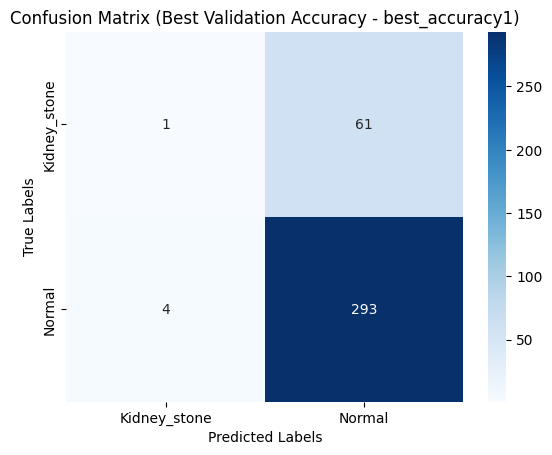

In [34]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names1, yticklabels=class_names1)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Validation Accuracy - best_accuracy1)')
plt.show()